In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from sklearn import metrics

Found 3249 images belonging to 2 classes.
Found 852 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        18464     
                                       

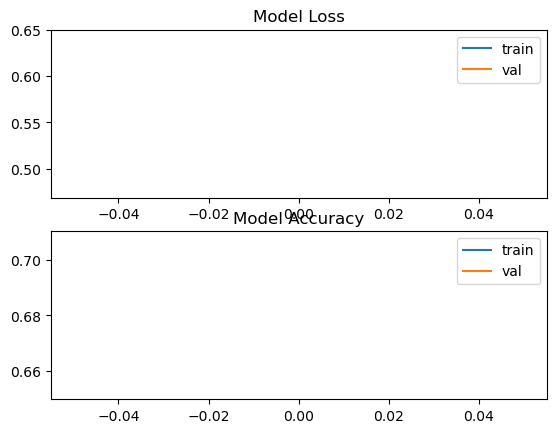

27/27 [==============================] - 12s 421ms/step
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       566
           1       0.55      0.72      0.62       286

    accuracy                           0.71       852
   macro avg       0.69      0.71      0.69       852
weighted avg       0.74      0.71      0.71       852



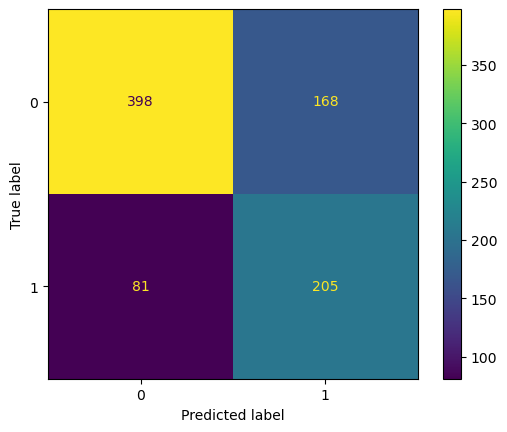

In [2]:
if __name__ == "__main__":
    training_dataset_path = (
        "C:/Users/User/PycharmProjects/CodeAcademy/Galutinis_projektas/Photos_train/"
    )
    validation_dataset_path = (
        "C:/Users/User/PycharmProjects/CodeAcademy/Galutinis_projektas/Photos_val/"
    )
    test_dataset_path = (
        "C:/Users/User/PycharmProjects/CodeAcademy/Galutinis_projektas/Photos_test/"
    )
    path_to_save_model = (
        "C:/Users/User/PycharmProjects/CodeAcademy/Galutinis_projektas/model/"
    )
    model_name = f"binary_v1._augmented_dataset"
    os.makedirs(path_to_save_model, exist_ok=True)
    image_size = (128, 128)
    epochs = 1
    batch_size = 32
    threshold = 0.5

    train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

    test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        training_dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
    )

    val_generator = test_datagen.flow_from_directory(
        validation_dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
        shuffle=False,
    )

    steps_per_epoch = int(np.floor(val_generator.samples / batch_size))

    # Initialising the CNN
    model = keras.models.Sequential()
    # Create convolutional layer. There are 3 dimensions for input shape
    model.add(
        layers.Conv2D(128, (3, 3), activation="relu", input_shape=image_size + (3,))
    )
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=512, activation="relu"))
    model.add(layers.Dense(units=256, activation="relu"))
    model.add(layers.Dense(units=128, activation="relu"))
    model.add(layers.Dense(units=1, activation="sigmoid"))
    model.summary()

    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(path_to_save_model, f"{model_name}.hdf5"),
        monitor="val_loss",
        save_best_only=True,
        mode=min,
    )

    # Compiling the CNN
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.BinaryAccuracy()],
    )

    # Fitting the CNN
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        steps_per_epoch=steps_per_epoch,
        callbacks=[checkpoint],
    )

    # plot loss during training
    plt.subplot(211)
    plt.title("Model Loss")
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title("Model Accuracy")
    plt.plot(history.history["binary_accuracy"], label="train")
    plt.plot(history.history["val_binary_accuracy"], label="val")
    plt.legend()
    plt.show()

    tf.keras.backend.clear_session()

    predicted_classes = model.predict(val_generator, verbose=1)

    predicted_classes = [1 if pred[0] > threshold else 0 for pred in predicted_classes]
    gt_classes = val_generator.classes

    print(classification_report(gt_classes, predicted_classes))
    confusion_matrix = metrics.confusion_matrix(gt_classes, predicted_classes)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=["0", "1"]
    )
    cm_display.plot()
    plt.show()